In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# https://towardsdatascience.com/a-deep-learning-approach-in-predicting-the-next-word-s-7b0ee9341bfe
import nltk
import string
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

from keras import backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# read-in cleaned data and parse.
# path = '../data/'
path = '/content/drive/MyDrive/Colab Notebooks/'
filepath = path + 'allphishsets.csv'

df = pd.read_csv(filepath)
df = df.sort_values(by=['showdate', 'set', 'position'],
                    ascending=[True, True, True])

df.loc[df['times_played'] <= 2, 'slug'] = 'wildcard'
df.loc[df['times_played'] <= 2, 'times_played'] = 510

songstring = df[['showdate', 'set', 'slug']].groupby(['showdate', 'set'])['slug']\
                                            .apply(lambda x: '|'.join(x)).reset_index()
songstring['full'] = songstring.apply(lambda row: f"set-{row['set']}|{row['slug']}", axis=1)

songstring = songstring[['showdate', 'full']].groupby(['showdate'])['full']\
                                             .apply(lambda x: '|'.join(x)).reset_index()

songstring['full'] += '|eos'

In [ ]:
# NLP the setlists via n-gram model
corpus = [''.join(map(lambda s: s.replace('|', ' '), f))
          for f in songstring['full']]

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(corpus)
word_index = tokenizer.word_index
unique_words = len(tokenizer.word_index) + 1

max_seq_length = max([len(setlist.split(' ')) for setlist in corpus]) - 1

def NGramSequences(corpus: list, tokenizer: Tokenizer, max_seq_length=None):
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_seqs = token_list[:i+1]
            input_sequences.append(n_gram_seqs)
    if max_seq_length is None:
        max_seq_length = max([len(x) for x in input_sequences])
    input_seqs = np.array(
        pad_sequences(input_sequences, maxlen=max_seq_length, padding='pre')
    )
    return input_seqs

input_seqs = NGramSequences(
    corpus=corpus, tokenizer=tokenizer, max_seq_length=max_seq_length
)

x_values, labels = input_seqs[:, :-1], input_seqs[:, -1]
y_values = tf.keras.utils.to_categorical(labels,
                                         num_classes=unique_words)

# get directed graph adjacency matrix as embeddings matrix
corpus_list = [
    song for songs in
    [setlist.split(' ') for setlist in corpus]
    for song in songs
]

tw_idx = tokenizer.word_index

coocurrence_matrix = np.zeros((unique_words, unique_words))
for i in trange(len(corpus_list)):
    if i == 0:
        continue
    song_a = tw_idx[corpus_list[i-1]]
    song_b = tw_idx[corpus_list[i]]
    coocurrence_matrix[song_a][song_b] += 1

# Laplace smooth
coocurrence_matrix += 1
embeddings_matrix = coocurrence_matrix / np.sum(coocurrence_matrix, axis=1, keepdims=True)

100%|██████████| 39849/39849 [00:00<00:00, 883719.86it/s]


In [ ]:
K.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=unique_words, output_dim=unique_words,
        weights=[embeddings_matrix], input_length=input_seqs.shape[1]-1,
        trainable=False
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(unique_words, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

early_stop = EarlyStopping(
    monitor='val_accuracy', patience=20, min_delta=0.0001, mode='max',
    start_from_epoch=10, restore_best_weights=True
)

history = model.fit(
    x_values, y_values,
    epochs=120, batch_size=1024,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/120
30/30 [==============================] - 21s 433ms/step - loss: 5.4975 - accuracy: 0.0401 - val_loss: 6.0545 - val_accuracy: 0.0431
Epoch 2/120
30/30 [==============================] - 11s 380ms/step - loss: 5.1541 - accuracy: 0.0391 - val_loss: 6.0631 - val_accuracy: 0.0431
Epoch 3/120
30/30 [==============================] - 12s 402ms/step - loss: 5.1441 - accuracy: 0.0387 - val_loss: 6.1323 - val_accuracy: 0.0430
Epoch 4/120
30/30 [==============================] - 12s 394ms/step - loss: 5.1385 - accuracy: 0.0405 - val_loss: 6.1700 - val_accuracy: 0.0431
Epoch 5/120
30/30 [==============================] - 11s 375ms/step - loss: 5.1340 - accuracy: 0.0397 - val_loss: 6.1527 - val_accuracy: 0.0430
Epoch 6/120
30/30 [==============================] - 11s 373ms/step - loss: 5.1238 - accuracy: 0.0400 - val_loss: 6.1426 - val_accuracy: 0.0533
Epoch 7/120
30/30 [==============================] - 11s 372ms/step - loss: 5.0689 - accuracy: 0.0423 - val_loss: 6.1109 - val_accuracy:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 491)           241081    
                                                                 
 bidirectional (Bidirection  (None, 55, 512)           1531904   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 55, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 512)               1574912   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense (Dense)               (None, 128)               6

Text(0.5, 1.0, 'Next Song Accuracy')

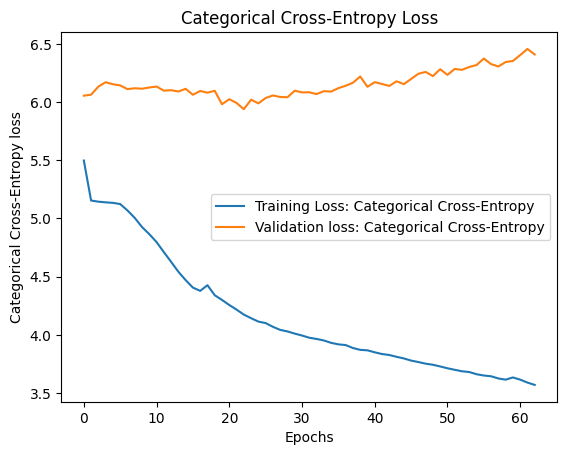

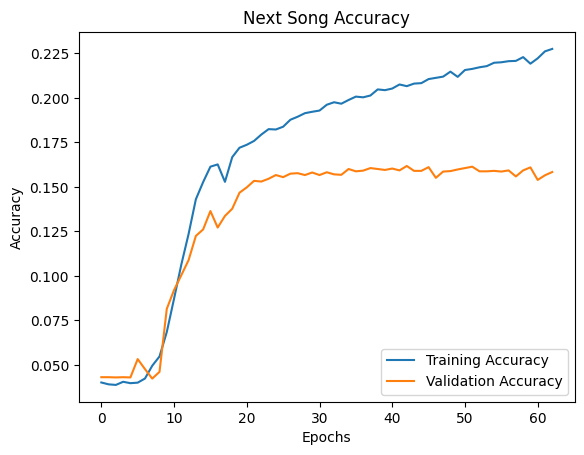

In [ ]:
print(model.summary())

loss = 'Categorical Cross-Entropy'

plt.figure()
plt.plot([ l for l in history.history['loss'] ],
         label=f'Training Loss: {loss}')
plt.plot([ l for l in history.history['val_loss'] ],
         label=f'Validation loss: {loss}')

plt.xlabel('Epochs')
plt.ylabel(f'{loss} loss')
plt.legend(loc='center right')
plt.title(f"{loss} Loss")

plt.figure()
plt.plot([ l for l in history.history['accuracy'] ],
         label=f'Training Accuracy')
plt.plot([ l for l in history.history['val_accuracy'] ],
         label=f'Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel(f'Accuracy')
plt.legend(loc='lower right')
plt.title("Next Song Accuracy")

In [ ]:
def prediction(seed_text, next_words):
  for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_seq_length-1, padding='pre')
    predicted = np.argmax(model.predict(token_list, verbose=1), axis=-1)[0]
    print(predicted)
    ouput_word = ""
    for word, index in tokenizer.word_index.items():
      if index == predicted:
        output_word = word
        break
    seed_text += ' '+output_word
    print(seed_text)
seed_phrase = corpus[-3:-2][0] + ' set-1'
print(seed_phrase)
next_words = len("with us, patronize us and do nothing in the end".split())
prediction(seed_phrase, next_words)

set-1 carini rift halleys-comet ghost albuquerque saw-it-again foam blaze-on meat drift-while-youre-sleeping set-2 sand waves tweezer crosseyed-and-painless light mountains-in-the-mist golgi-apparatus harry-hood talk harry-hood set-e izabella eos set-1
1/1 [==============================] - 0s 23ms/step
19
set-1 carini rift halleys-comet ghost albuquerque saw-it-again foam blaze-on meat drift-while-youre-sleeping set-2 sand waves tweezer crosseyed-and-painless light mountains-in-the-mist golgi-apparatus harry-hood talk harry-hood set-e izabella eos set-1 suzy-greenberg
1/1 [==============================] - 0s 21ms/step
40
set-1 carini rift halleys-comet ghost albuquerque saw-it-again foam blaze-on meat drift-while-youre-sleeping set-2 sand waves tweezer crosseyed-and-painless light mountains-in-the-mist golgi-apparatus harry-hood talk harry-hood set-e izabella eos set-1 suzy-greenberg also-sprach-zarathustra
1/1 [==============================] - 0s 21ms/step
29
set-1 carini rift hall

In [ ]:
# generate predictions until num predictions or Set 1
def generate_predictions(model: tf.keras.Model,
                         seed_sequence: list,
                         stop_song_index: int):
    predicted_sequence = seed_sequence.copy()
    next_song_index = 0
    last_song_pad = [0] * (max_seq_length-1) + [1]
    predicted_sequence = np.vstack((predicted_sequence, last_song_pad))
    print(predicted_sequence)

    while next_song_index != stop_song_index:
        next_song_index = np.argmax(model.predict(predicted_sequence, verbose=1), axis=-1)[0]
        next_song_pad = [last_song_pad[1:] + [next_song_index]][0]
        print(predicted_sequence)
        print(next_song_index)
        print(last_song_pad)
        print(next_song_pad)
        predicted_sequence = np.vstack((predicted_sequence, next_song_pad))
        last_song_pad = list(predicted_sequence[-1])
    return predicted_sequence

seed_sequence = NGramSequences(
    corpus=corpus[-5:]+['set-1'], tokenizer=tokenizer, max_seq_length=max_seq_length
)

stop_song = 'eos'
stop_song_index = tokenizer.word_index[stop_song]

predicted_sequence = generate_predictions(
    model=model,
    seed_sequence=seed_sequence,
    stop_song_index=stop_song_index
)

# word_index_inv = {i: word for word, i in tokenizer.word_index.items()}

# # numerical predictions back to song names
# predicted_songs = [word_index_inv[i] for i in predicted_sequence]

[[  0   0   0 ...   0   1 235]
 [  0   0   0 ...   1 235   6]
 [  0   0   0 ... 235   6  66]
 ...
 [  0   0   0 ...  13 212  27]
 [  0   0   0 ... 212  27   4]
 [  0   0   0 ...   0   0   1]]
4/4 [==============================] - 0s 13ms/step
[[  0   0   0 ...   0   1 235]
 [  0   0   0 ...   1 235   6]
 [  0   0   0 ... 235   6  66]
 ...
 [  0   0   0 ...  13 212  27]
 [  0   0   0 ... 212  27   4]
 [  0   0   0 ...   0   0   1]]
22
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 22]
4/4 [==============================] - 0s 13ms/step
[[  0   0   0 ...   0   1 235]
 [  0   0   0 ...   1 235   6]
 [  0   0   0 ... 235   6  66]
 ...
 [  0   0   0 ... 212  27   4]
 [  0   0   0 ...   0   0   1]
 [  0   0   0 ..

KeyboardInterrupt: ignored

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   1, 235], dtype=int32)